In [8]:
# required libraries
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn import svm
from sklearn.datasets import make_moons, make_blobs
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from matplotlib.legend_handler import HandlerLine2D
from sklearn.model_selection import GridSearchCV
import KitNET as kit
import numpy as np
import pandas as pd
import time

In [70]:
df= pd.read_csv("random_sample")
start_time = df['Time'].min()
end_time = df['Time'].max()
hour_bins = np.arange(start_time - 1, end_time + 2, step = 3600)
df['Time'] = np.searchsorted(hour_bins, df['Time'].values)
df['SrcPort'].replace(regex = True, inplace = True, to_replace = r'\D', value = r'')
df['DstPort'].replace(regex = True, inplace = True, to_replace = r'\D', value = r'')
df['SrcDevice'].replace(regex = True, inplace = True, to_replace = r'\d', value = r'')
df['DstDevice'].replace(regex = True, inplace = True, to_replace = r'\d', value = r'')
port_bins = [-1, 1023, 49151]
df['SrcPort'] = df['SrcPort'].astype(int)
df['DstPort'] = df['DstPort'].astype(int)
df['SrcPort'] = np.searchsorted(port_bins, df['SrcPort'].values)
df['DstPort'] = np.searchsorted(port_bins, df['DstPort'].values)
df['SrcDevice'] =df['SrcDevice'].astype('category')
df['DstDevice'] = df['DstDevice'].astype('category')
df['SrcPort'] =df['SrcPort'].astype('category')
df['DstPort'] = df['DstPort'].astype('category')
df['Time'] = df['Time'].astype('category')
df['Protocol'] = df['Protocol'].astype('category')
# data = pd.get_dummies(df)
# #max scaling
# data["SrcBytes"] = np.log((data["SrcBytes"])+0.001)
# data["DstBytes"] = np.log((data["DstBytes"])+0.001)
# data["SrcPackets"] = np.log((data["SrcPackets"])+0.001)
# data["DstPackets"] = np.log((data["DstPackets"])+0.001)
# data["Duration"] = np.log((data["Duration"])+0.001)
#setting threshold for outliers
outliers_fraction = 0.05

In [9]:
# KitNET params:
maxAE = 10 #maximum size for any autoencoder in the ensemble layer
FMgrace = 5000 #the number of instances taken to learn the feature mapping (the ensemble's architecture)
ADgrace = 50000 #the number of instances used to train the anomaly detector (ensemble itself)

In [11]:
# Build KitNET
K = kit.KitNET(data.shape[1],maxAE,FMgrace,ADgrace)
RMSEs = np.zeros(data.shape[0]) # a place to save the scores

Feature-Mapper: train-mode, Anomaly-Detector: off-mode


In [18]:
print("Running KitNET:")
start = time.time()
# Here we process (train/execute) each individual observation.
# In this way, X is essentially a stream, and each observation is discarded after performing process() method.
for i in range(data.shape[0]):
    if i % 1000 == 0:
        print(i)
    RMSEs[i] = K.process(data.loc[i,]) #will train during the grace periods, then execute on all the rest.
stop = time.time()
print("Complete. Time elapsed: "+ str(stop - start))

Running KitNET:
0
1000
2000
3000
4000
5000
The Feature-Mapper found a mapping: 23 features to 13 autoencoders.
Feature-Mapper: execute-mode, Anomaly-Detector: train-mode
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
Feature-Mapper: execute-mode, Anomaly-Detector: exeute-mode
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
Complete. Time elapsed: 1556.1323838233948


In [26]:
sum(RMSEs)

407.7356957896625

In [ ]:
df = pd.DataFrame(data = RMSEs, index=False)

In [34]:
df.reset_index(inplace=True)
df.head()

,level_0,index,0
0,0,0,0.0
1,1,1,0.0
2,2,2,0.0
3,3,3,0.0
4,4,4,0.0


In [39]:
df.columns = ["RMSE"]

In [37]:
df = df.drop(["level_0","index"], axis = 1)

In [49]:
auto_data = pd.concat([data, df], axis = 1)

In [57]:
auto_data["RMSE"].mean()

0.004077356957896625

In [62]:
auto_data["RMSE"].std()

0.015994825154618295

In [60]:
auto_data["RMSE"].max()

0.33244704621250426

In [61]:
auto_data["RMSE"].min()

0.0

In [63]:
auto_data["label"] = [1 if x > auto_data["RMSE"].mean() + 3* auto_data["RMSE"].std() else 0 for x in auto_data["RMSE"]]

In [64]:
auto_data.label.value_counts()

0    98366
1     1634
Name: label, dtype: int64

In [65]:
resp_variables = data.T.tail(1).T
pred_variables = data.T.head(23).T
scaler = StandardScaler()
pred_variables[pred_variables.columns] = scaler.fit_transform(pred_variables[pred_variables.columns])
pca = PCA(n_components=2)
X = pred_variables
X_r = pca.fit_transform(X)
X_c = pd.concat([pd.DataFrame(data=X_r).reset_index(drop=True), resp_variables], axis=1)
X_c.columns = ['PC1', 'PC2','label']

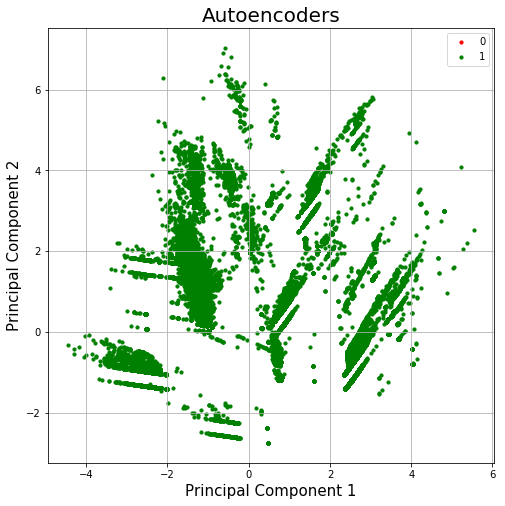

In [67]:
#Isolation Forest
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Autoencoders', fontsize = 20)
targets = [0,1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = X_c['label'] == target
    ax.scatter(X_c.loc[indicesToKeep, 'PC1']
               , X_c.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 10)
ax.legend(targets)
ax.grid()

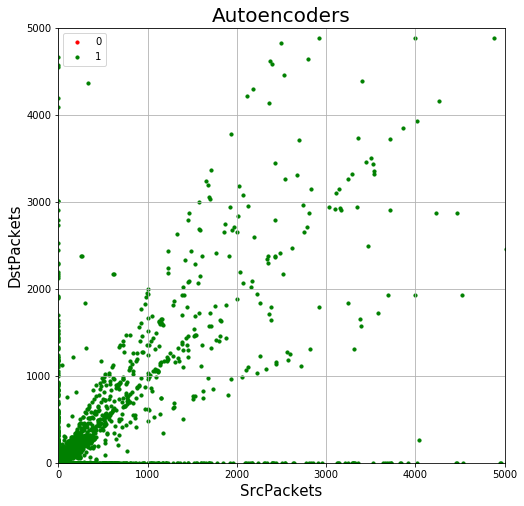

In [72]:
#Isolation Forest
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('SrcPackets', fontsize = 15)
ax.set_ylabel('DstPackets', fontsize = 15)
ax.set_title('Autoencoders', fontsize = 20)
targets = [0,1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = X_c['label'] == target
    ax.scatter(df.loc[indicesToKeep, 'SrcPackets']
               , df.loc[indicesToKeep, 'DstPackets']
               , c = color
               , s = 10)
ax.set_xlim([0, 5000])
ax.set_ylim([0, 5000])
ax.legend(targets)
ax.grid()

In [90]:
#train-test splitting
nonanom = auto_data[auto_data.label == 0]
anom = auto_data[auto_data.label == 1]
nonanom_sample = nonanom.sample(frac=0.03, replace=True, random_state=1)
labelled = anom.append(nonanom_sample)
X = labelled.T.head(23).T
Y = labelled.T.tail(1).T
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [91]:
labelled.label.value_counts()

0    2951
1    1634
Name: label, dtype: int64

In [75]:
#function for plotting confusion Matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[933   9]
 [  0 572]]


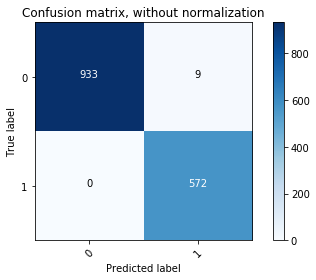

In [92]:
LR = LogisticRegressionCV(cv=5, random_state=0).fit(X_train, y_train)
pred_y=LR.predict(X_test)
cm= confusion_matrix(y_test,pred_y)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],title='Confusion matrix, without normalization')

In [93]:
tn, fp, fn, tp = cm.ravel()
precision=tp/(tp+fp)
recall=tp/(tp+fn)
fpr = fp/(fp+ tn)
accuracy = (tp + tn)/(tn + tp + fn + fp)
print(precision, recall, fpr*100, accuracy*100)

0.9845094664371773 1.0 0.9554140127388535 99.40554821664465


Confusion matrix, without normalization
[[933   9]
 [  0 572]]


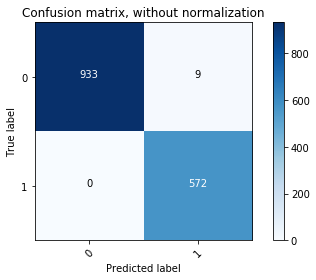

In [101]:
#Random Forest
m = RandomForestClassifier(n_estimators=10000, min_samples_leaf=2, max_features=0.5, n_jobs=-1)
m.fit(X_train, y_train)
pred_y=m.predict(X_test)
cm= confusion_matrix(y_test,pred_y)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],title='Confusion matrix, without normalization')

In [102]:
tn, fp, fn, tp = cm.ravel()
precision=tp/(tp+fp)
recall=tp/(tp+fn)
fpr = fp/(fp+ tn)
accuracy = (tp + tn)/(tn + tp + fn + fp)
print(precision, recall, fpr*100, accuracy*100)

0.9845094664371773 1.0 0.9554140127388535 99.40554821664465


In [ ]:
labelled_data.csv